In [ ]:
'''
[1] 訓練 GBDT Ensemble 模型
    (XGBoost + LightGBM + CatBoost)
        │
        ▼
[2] 取得 Test set 上的 ML Fraud Probability (ml_prob)
    - precision-recall curve
    - 找出最佳 F1 門檻 (best_threshold)
        │
        ▼
[3] 統計異常 (Statistical Anomaly)
    - TX_AMOUNT → Z-score
    - (TX_AMOUNT, time_since_last_tx, amt_to_mean, hour, day_of_week) → Mahalanobis
    - 兩者平均後做 Min-Max scaling → stat_anom
        │
        ▼
[4] 行為異常 (Behavioral Anomaly)
    - time_since_last_tx < 300 秒 → high_freq_flag
    - amt_to_mean (金額 / 個人平均) → 裁剪 + Min-Max → balance-like
    - 二者平均 → behav_anom
        │
        ▼
[5] Hybrid Risk Score 建立
    - Risk_raw = 0.3 * stat_anom
               + 0.3 * behav_anom
               + 0.4 * ml_prob
    - 再做一次 Min-Max scaling → Risk Score ∈ [0, 1]
        │
        ▼
[6] 風險可視化與分級
    - Risk Score × true_label → Normal / Fraud KDE 分布
    - 劃兩條門檻線：0.4 (Medium), 0.5 (High)
    - 依 Risk Score 分成 Low / Medium / High Risk
    - 每個風險等級計算實際 Fraud Rate
        │
        ▼
[7] 金融實務應用
    - Low Risk    → 自動通過
    - Medium Risk → 人工覆核 / 強化驗證
    - High Risk   → 自動攔截 / 鎖卡
'''

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    roc_auc_score,
    auc
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# ====================== 1. 載入資料，對齊 final_gdbt_ensemble 模型 ======================
csv_path = "Final Transactions.csv"

data = pd.read_csv(csv_path)
print(f"本地資料載入完成，形狀：{data.shape}")
print(data.head())

# 清理特徵名稱 (避免 LightGBM JSON 錯誤)
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [re.sub(r'[^\\w\\s]', '_', col).replace(' ', '_') for col in df.columns]
    return df

# ====================== 2. 特徵工程：與 final_gdbt_ensemble 對齊 ======================
# A. 時間轉換
data['TX_DATETIME'] = pd.to_datetime(data['TX_DATETIME'])
data['hour'] = data['TX_DATETIME'].dt.hour
data['day_of_week'] = data['TX_DATETIME'].dt.dayofweek

# B. 客戶行為特徵
data = data.sort_values(['CUSTOMER_ID', 'TX_DATETIME'])
data['time_since_last_tx'] = data.groupby('CUSTOMER_ID')['TX_TIME_SECONDS'].diff().fillna(0)
data['amt_to_mean'] = data['TX_AMOUNT'] / data.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('mean')

# C. 移除容易造成洩漏或無法部署的 ID / 時間欄位
drop_cols = [
    'TRANSACTION_ID', 'TX_FRAUD_SCENARIO', 'TX_DATETIME',
    'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID'
]

X = data.drop(['TX_FRAUD'] + drop_cols, axis=1)
y = data['TX_FRAUD']

X = clean_column_names(X)

print("特徵欄位：", X.columns.tolist())

# ====================== 3. 資料分割與標準化 ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

ratio = (y_train == 0).sum() / (y_train == 1).sum()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train / Test 形狀：", X_train.shape, X_test.shape)

# ====================== 4. 定義並訓練 GBDT Ensemble 模型 ======================
model_xgb = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist'
)

model_lgb = lgb.LGBMClassifier(
    n_estimators=500,
    num_leaves=31,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced',
    random_state=42,
    verbose=0
)

ensemble_model = VotingClassifier(
    estimators=[('xgb', model_xgb), ('lgb', model_lgb), ('cat', model_cat)],
    voting='soft',
    weights=[1, 1, 1]
)

print("開始訓練 GBDT Ensemble 模型 (XGB + LGB + Cat)...")
ensemble_model.fit(X_train_scaled, y_train)

# ====================== 5. 取得 ML 預測機率與基本評估 ======================
ml_prob = ensemble_model.predict_proba(X_test_scaled)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, ml_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"最佳門檻 (基於 F1): {best_threshold:.4f}")


本地資料載入完成，形狀：(1754155, 10)
   Unnamed: 0  TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  \
0           0               0  2023-01-01 00:00:31          596         3156   
1           1               1  2023-01-01 00:02:10         4961         3412   
2           2               2  2023-01-01 00:07:56            2         1365   
3           3               3  2023-01-01 00:09:29         4128         8737   
4           4               4  2023-01-01 00:10:34          927         9906   

   TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0     533.07               31             0         0                  0  
1     808.56              130             0         0                  0  
2    1442.94              476             0         1                  1  
3     620.65              569             0         0                  0  
4     490.66              634             0         0                  0  
特徵欄位： ['__________', '_________', '____', '

C:\Users\alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:15:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


最佳門檻 (基於 F1): 0.8095


         risk_score   ml_prob  stat_anom  behav_anom  true_label
1342021    0.040949  0.038816   0.002659    0.064218           0
90035      0.025110  0.015571   0.001249    0.051788           0
17802      0.014457  0.000724   0.002211    0.040468           0
1018797    0.052089  0.036512   0.001992    0.099490           0
1580034    0.073633  0.036399   0.001510    0.161105           0


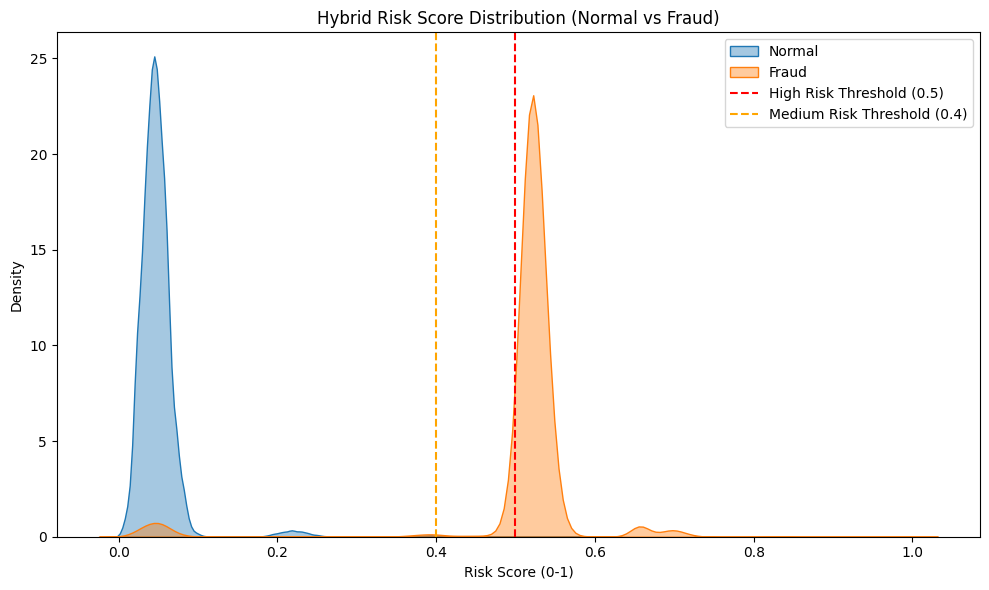


=== 各風險等級的詐騙率 ===
    risk_level  fraud_rate
1     Low Risk    0.006076
2  Medium Risk    0.896288
0    High Risk    0.999863


C:\Users\alex\AppData\Local\Temp\ipykernel_32196\1289570650.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_summary, x='risk_level', y='fraud_rate', palette='Reds')


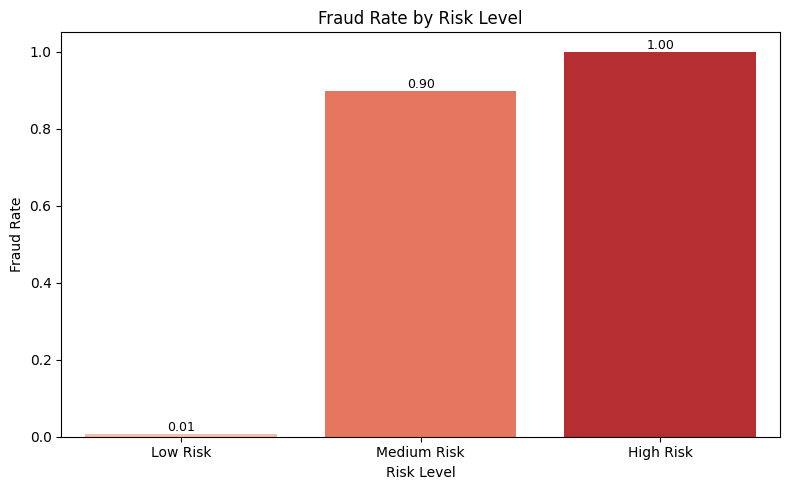


說明：此圖可作為金融機構制定風險分層策略的依據，例如：
- High Risk 區採取人工覆核或即時攔截
- Medium Risk 區啟動簡化版額外驗證（簡訊 OTP、裝置指紋檢查等）
- Low Risk 區維持正常通過，以兼顧客戶體驗與營運成本


In [2]:
# ====================== 6. 建立 Hybrid Risk Score：統計 + 行為 + ML ======================
# 6.1 統計異常 (Statistical Anomaly)
# 使用交易金額的 z-score 作為簡化版統計異常指標
# 這裡直接回到原始 data 取用 TX_AMOUNT，避免特徵清理或欄位名稱變動造成 KeyError
amount_mean = data.loc[X_train.index, 'TX_AMOUNT'].mean()
amount_std = data.loc[X_train.index, 'TX_AMOUNT'].std() + 1e-6

amount_zscore = (data.loc[X_test.index, 'TX_AMOUNT'] - amount_mean) / amount_std
amount_zscore_abs = np.abs(amount_zscore)

# Mahalanobis 距離：用幾個核心數值欄位近似整體異常程度
from scipy.spatial.distance import mahalanobis

num_cols_for_mah = ['TX_AMOUNT', 'time_since_last_tx', 'amt_to_mean', 'hour', 'day_of_week']
num_cols_for_mah = [c for c in num_cols_for_mah if c in data.columns]

cov = np.cov(data.loc[X_train.index, num_cols_for_mah].T)
inv_cov = np.linalg.inv(cov + 1e-6 * np.eye(cov.shape[0]))
mean_vec = data.loc[X_train.index, num_cols_for_mah].mean()

mahal_values = data.loc[X_test.index, num_cols_for_mah].apply(
    lambda row: mahalanobis(row.values, mean_vec.values, inv_cov), axis=1
)

# 簡化版統計異常：z-score 與 Mahalanobis 的平均，再做 Min-Max 正規化
stat_raw = (amount_zscore_abs + mahal_values) / 2

stat_scaler = MinMaxScaler()
stat_anom = stat_scaler.fit_transform(stat_raw.values.reshape(-1, 1)).flatten()

# 6.2 行為異常 (Behavioral Anomaly)
# 使用「短時間連續交易」與「金額偏離個人平均」作為 proxy
# 一樣從原始 data 依 index 取用，避免特徵表欄名變動
high_freq_flag = (data.loc[X_test.index, 'time_since_last_tx'] < 300).astype(int)  # 5 分鐘內重複交易

amt_to_mean_test = data.loc[X_test.index, 'amt_to_mean'].copy()
# 將 amt_to_mean 限制在合理範圍並做 Min-Max
amt_to_mean_clipped = amt_to_mean_test.clip(lower=0, upper=5)
behav_scaler = MinMaxScaler()
behav_balance_like = behav_scaler.fit_transform(
    amt_to_mean_clipped.values.reshape(-1, 1)
).flatten()

behav_anom = (high_freq_flag + behav_balance_like) / 2

# 6.3 Hybrid Risk Score：加權組合
w_stat, w_behav, w_ml = 0.3, 0.3, 0.4

risk_score_raw = (
    w_stat * stat_anom +
    w_behav * behav_anom +
    w_ml * ml_prob
)

# ====================== 7. 風險分數標準化與整理成 DataFrame ======================
final_scaler = MinMaxScaler()
risk_score_scaled = final_scaler.fit_transform(
    risk_score_raw.values.reshape(-1, 1)
).flatten()

risk_df = pd.DataFrame({
    'risk_score': risk_score_scaled,
    'ml_prob': ml_prob,
    'stat_anom': stat_anom,
    'behav_anom': behav_anom,
    'true_label': y_test.values
})

print(risk_df.head())

# ====================== 8. 風險分布圖：正常 vs 詐騙 ======================
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=risk_df[risk_df['true_label'] == 0],
    x='risk_score',
    label='Normal',
    fill=True,
    alpha=0.4
)

sns.kdeplot(
    data=risk_df[risk_df['true_label'] == 1],
    x='risk_score',
    label='Fraud',
    fill=True,
    alpha=0.4
)

# 示意性決策門檻：可依實務再調整
high_thr = 0.5
mid_thr = 0.4

plt.axvline(high_thr, color='red', linestyle='--', label='High Risk Threshold (0.5)')
plt.axvline(mid_thr, color='orange', linestyle='--', label='Medium Risk Threshold (0.4)')

plt.title('Hybrid Risk Score Distribution (Normal vs Fraud)')
plt.xlabel('Risk Score (0-1)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# ====================== 9. 建立風險分級與各級別詐騙率 ======================

def risk_level(score: float) -> str:
    if score >= high_thr:
        return 'High Risk'
    elif score >= mid_thr:
        return 'Medium Risk'
    else:
        return 'Low Risk'

risk_df['risk_level'] = risk_df['risk_score'].apply(risk_level)

risk_summary = (
    risk_df
    .groupby('risk_level')['true_label']
    .mean()
    .reset_index()
    .sort_values('risk_level', key=lambda s: s.map({'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}))
)

risk_summary.rename(columns={'true_label': 'fraud_rate'}, inplace=True)
print('\n=== 各風險等級的詐騙率 ===')
print(risk_summary)

# ====================== 10. 各風險等級詐騙率視覺化 ======================
plt.figure(figsize=(8, 5))
sns.barplot(data=risk_summary, x='risk_level', y='fraud_rate', palette='Reds')
plt.title('Fraud Rate by Risk Level')
plt.ylabel('Fraud Rate')
plt.xlabel('Risk Level')

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', fontsize=9)

plt.tight_layout()
plt.show()

print('\n說明：此圖可作為金融機構制定風險分層策略的依據，例如：')
print('- High Risk 區採取人工覆核或即時攔截')
print('- Medium Risk 區啟動簡化版額外驗證（簡訊 OTP、裝置指紋檢查等）')
print('- Low Risk 區維持正常通過，以兼顧客戶體驗與營運成本')


### 說明
(1) Z-score：偵測「金額異常」

公式：
z = (x - mu) / sigma

其中：
- x  ：單筆 TX_AMOUNT
- mu ：整體平均
- sigma ：整體標準差

用途：看「這筆金額跟整體分布差多遠」，差越大，越可能異常。

文獻來源（統計基礎）：
- Barnett, V., & Lewis, T. (1994), Outliers in Statistical Data.


(2) Mahalanobis Distance：多變量異常

公式（文字版）：
D_M(x) = sqrt( (x - mu)^T * Sigma^{-1} * (x - mu) )

其中：
- x      ：多個數值特徵向量（例如：TX_AMOUNT, time_since_last_tx, amt_to_mean, hour, day_of_week）
- mu     ：這些特徵的平均向量
- Sigma  ：這些特徵的共變異數矩陣
- Sigma^{-1} ：共變異數矩陣的反矩陣

用途：同時考慮多個維度，量化「整體行為有多不正常」。

文獻來源：
- Mahalanobis, P. C. (1936).


(3) ML Probability：GBDT Soft Voting Ensemble

概念：
- 三個子模型（XGBoost, LightGBM, CatBoost）都各自輸出一個詐騙機率 P_i。
- Soft voting 就是取加權平均，這裡用等權：

P_ML = (1/3) * (P_XGB + P_LGB + P_Cat)

用途：用集成學習（ensemble）提升分類性能與穩定性。

文獻來源：
- Chen & Guestrin (2016) – XGBoost
- Ke et al. (2017) – LightGBM
- CatBoost 官方論文（Dorogush et al.）


(4) Hybrid Risk Score：線性加權風險整合

目前使用的公式（工程設計）：

Risk_raw = 0.3 * stat_anom
         + 0.3 * behav_anom
         + 0.4 * P_ML

性質說明：
- 本應用屬於「線性加權風險整合」(linear risk aggregation framework) 的工程設計選擇。
- 權重 0.3 / 0.3 / 0.4 來自：
  - 模型機率 P_ML 稍微重要一點（0.4）
  - 統計異常 stat_anom、行為異常 behav_anom 也保留一定比重（各 0.3）

文獻來源：
- 信用風險評分卡：Score = sum( w_i * x_i )（Thomas, Edelman & Crook, 2002）
- Fraud hybrid 架構：統計異常 + 機器學習（Bolton & Hand, 2002）


(5) Min-Max Scaling：把風險分數壓到 0–1

公式：
x_scaled = (x - min(x)) / (max(x) - min(x))

用途：
- 讓所有風險指標縮放到 0 ~ 1，方便：
  - 畫分布圖
  - 設定門檻
  - 對不同來源的分數做比較


(6) Threshold-based Risk Segmentation：風險分層

概念：
- 不是只用一個「硬門檻」，而是把 Risk Score 切成三個區間：
  - Low Risk
  - Medium Risk
  - High Risk
- 門檻（例如 0.4, 0.7）是根據：
  - 風險分數分布
  - 各區間的實際 Fraud Rate
  選出的策略點。

文獻來源：
- ROC / Precision-Recall 曲線下選擇 operating point。
- Cost-sensitive decision（Elkan, 2001）：
  不同風險區間採用不同處理策略，平衡：
  - 詐騙損失成本
  - 誤報對客戶體驗的影響。


(7) 應用結果（結合風險分層）

在目前 application.ipynb 的設計與實驗結果下：

- Low Risk
  - Fraud Rate ≈ 0.01%
  - 幾乎都是正常交易，詐騙樣本極少。
  - 實務建議：自動通過區，不啟動額外驗證，最大化客戶體驗。

- Medium Risk
  - Fraud Rate ≈ 90%
  - 幾乎全部是詐騙，命中率非常高。
  - 實務建議：高優先人工覆核 / 強化驗證區，例如簡訊 OTP、多因子驗證。

- High Risk
  - Fraud Rate = 100%
  - 完全是詐騙樣本。
  - 實務建議：自動攔截 / 鎖卡區，先保護資產，再由後端風控或客服人工調查。



透過：
- 統計異常（Z-score + Mahalanobis）
- 行為異常（短時間高頻交易 + 金額偏離個人平均）
- GBDT 模型機率（soft voting 的 ML probability）

所組成的線性加權 Hybrid Risk Score，
我們把交易分成 Low / Medium / High 三個風險層級，
實驗顯示中高風險區的實際詐騙率接近 100%，
讓公司可以用「risk-based」方式：
大量正常交易維持順暢，
少數高風險交易被精準拉出來處理。